# **Diamonds Exploratory Data Analysis**
**4C's - Carat, Clarity, Colour and Cut**

![imgs](https://i.pinimg.com/736x/ee/20/82/ee208232377a87b77968813534eb707a.jpg)



In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from GemAI.utils import get_path

## Loading and Preprocessing

In [4]:
data_dir = get_path("Data/diamonds.csv")
df = pd.read_csv(data_dir).drop(columns='Unnamed: 0')
print(df.dtypes)
df

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [5]:
def preprocess_data(df, exchange_rate=13.5):
    """
    Preprocess the diamond DataFrame with the following steps:
    - Convert:  price [ USD -> BWP] 
                float32 
                categorical columns to category dtype
    - add 'volume' feature from the dimensions x, y, z
    """
    
    df['price_bwp'] = (df['price'] * exchange_rate).round(2)
    
    numeric_cols = ['carat', 'depth', 'table', 'x', 'y', 'z', 'price']
    df[numeric_cols] = df[numeric_cols].astype('float32')
    
    categorical_cols = ['cut', 'color', 'clarity']
    df[categorical_cols] = df[categorical_cols].apply(lambda col: col.astype('category'))
    
    # Create volume feature
    df['volume'] = (df['x'] * df['y'] * df['z']).astype('float32')
    
    # drop other
    df = df.drop(columns=['x', 'y', 'z', 'price'])
    
    # summary info
    print("\nOptimized df:")
    print(df.info())
    print("\nSample Data:")
    print(df.head())

    
    return df
df_processed = preprocess_data(df)


Optimized df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   carat      53940 non-null  float32 
 1   cut        53940 non-null  category
 2   color      53940 non-null  category
 3   clarity    53940 non-null  category
 4   depth      53940 non-null  float32 
 5   table      53940 non-null  float32 
 6   price_bwp  53940 non-null  float64 
 7   volume     53940 non-null  float32 
dtypes: category(3), float32(4), float64(1)
memory usage: 1.4 MB
None

Sample Data:
   carat      cut color clarity      depth  table  price_bwp     volume
0   0.23    Ideal     E     SI2  61.500000   55.0     4401.0  38.202034
1   0.21  Premium     E     SI1  59.799999   61.0     4401.0  34.505856
2   0.23     Good     E     VS1  56.900002   65.0     4414.5  38.076889
3   0.29  Premium     I     VS2  62.400002   58.0     4509.0  46.724579
4   0.31     Good     J

## handling missingless and outliers 

1. remove 0 volume this doesnt make sense
2. outliers

In [6]:
df_filtered = df_processed[df_processed['volume'] != 0]

lets look at the outlier if any

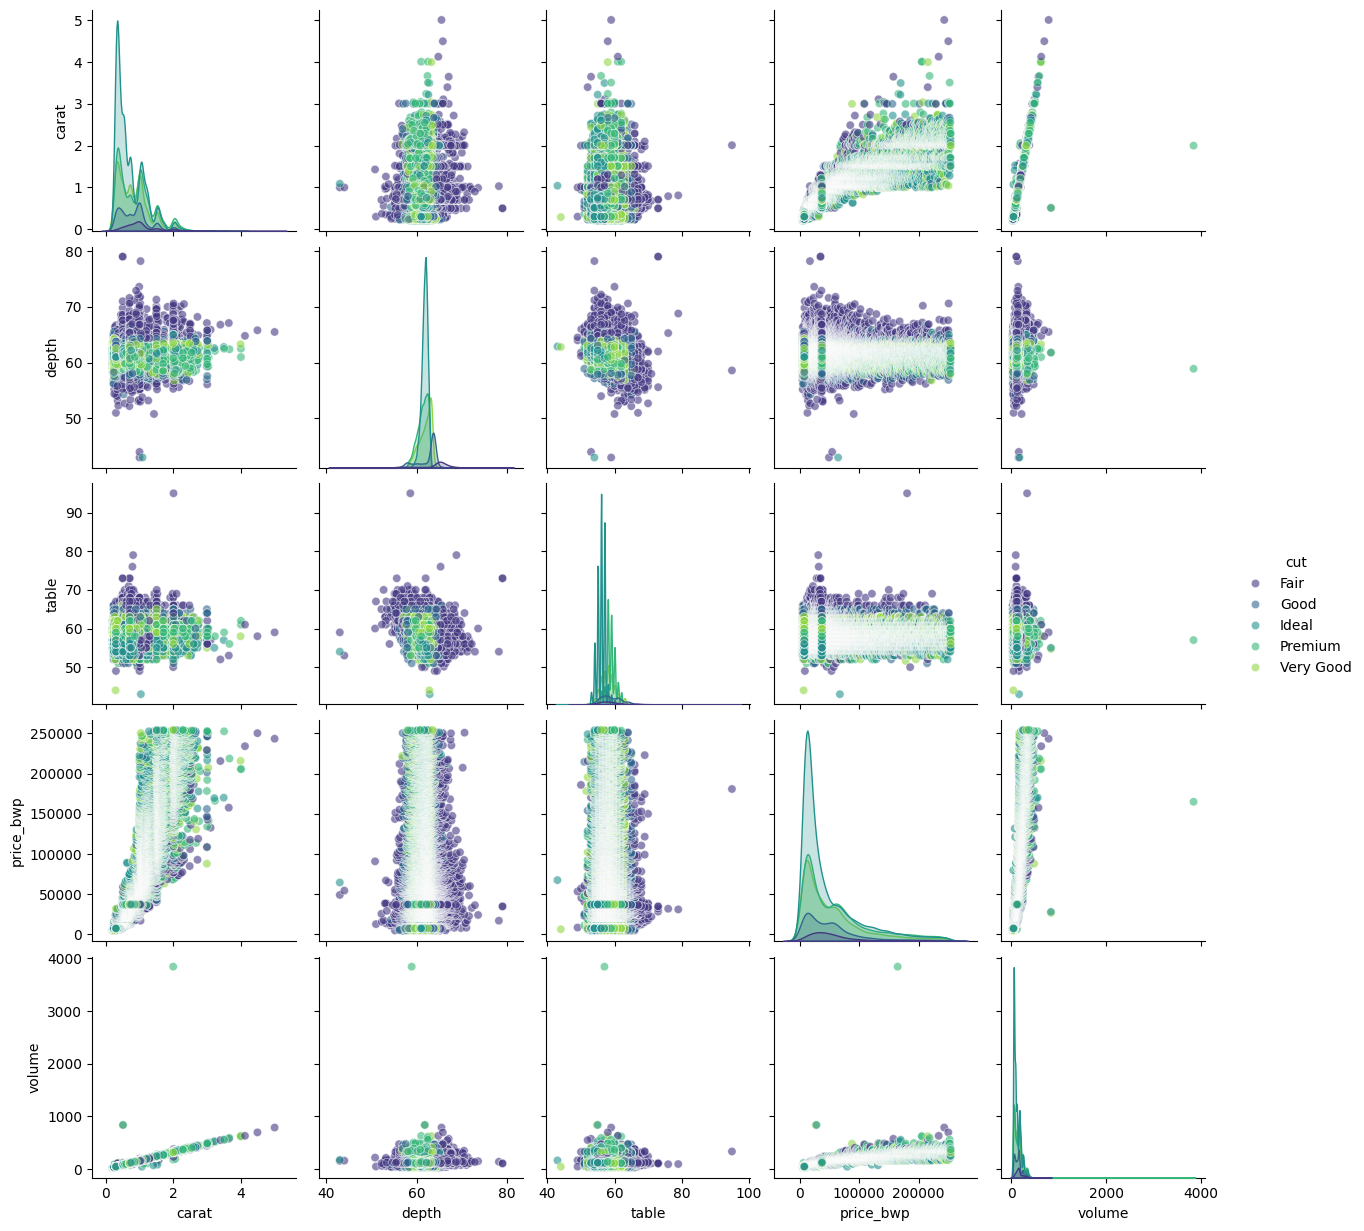

In [7]:
sns.pairplot(df_filtered, 
             hue='cut', palette='viridis', plot_kws={'alpha':0.6})

some obvious outliers... lets take of them.

In [9]:
def remove_outliers_iqr(df, factor=1.5, target_col="price_bwp"):
    """Remove outliers from numeric feature columns using IQR (excludes target)."""

    numeric_cols = df.select_dtypes(include=[np.number]).columns

    # Exclude target column
    numeric_cols = numeric_cols.drop(target_col, errors="ignore")
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR

    mask = ((df[numeric_cols] >= lower_bound) &
            (df[numeric_cols] <= upper_bound)).all(axis=1)

    return df[mask]




df_clean = remove_outliers_iqr(df_filtered, 2)
print(f"Original shape: {df_processed.shape}")
print(f"filtered shape: {df_filtered.shape}")
print(f"Cleaned shape: {df_clean.shape}")


Original shape: (53940, 8)
filtered shape: (53920, 8)
Cleaned shape: (52411, 8)


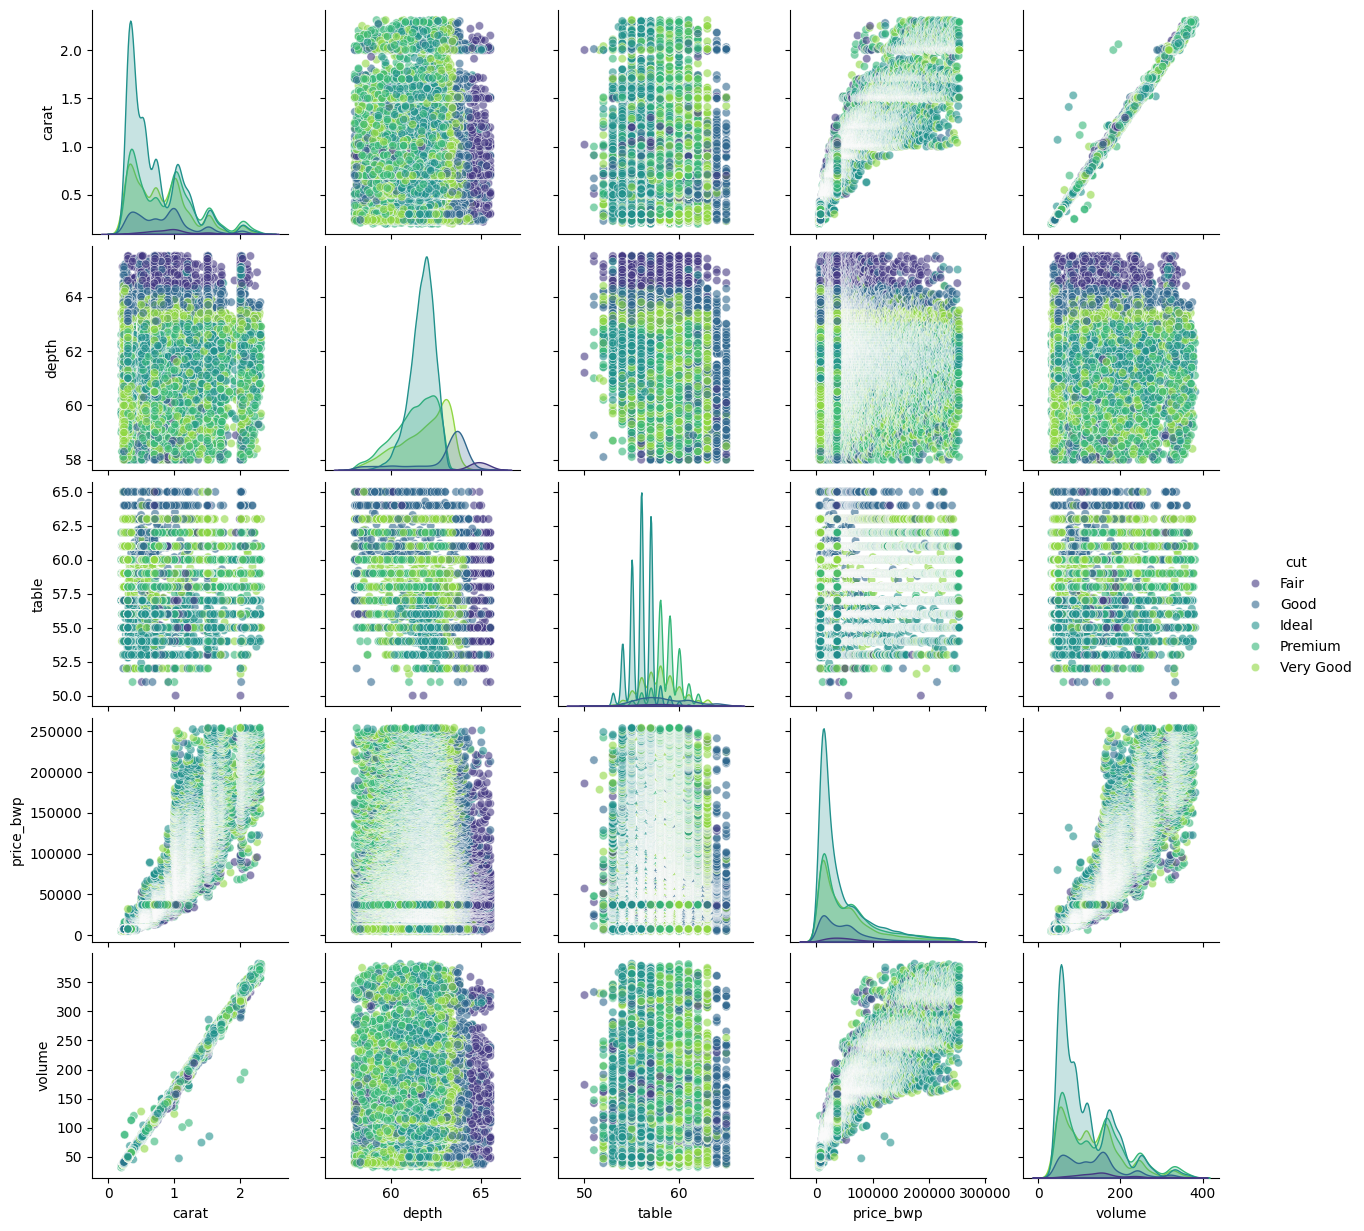

In [10]:
sns.pairplot(df_clean,
             hue='cut', palette='viridis', plot_kws={'alpha':0.6})

its a much better cleaner df

## Basic Statistics & Distributions

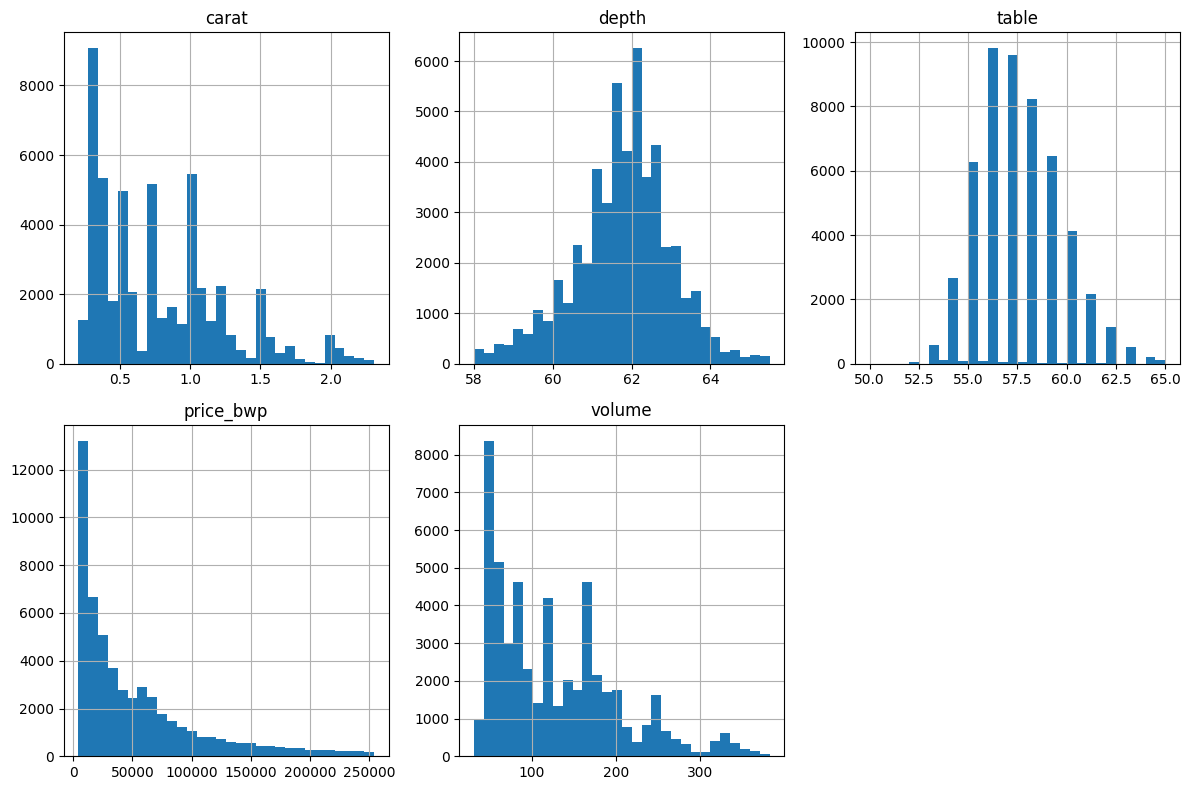

In [12]:
df_clean.hist(bins=30, figsize=(12, 8), layout=(2, 3))
plt.tight_layout()
plt.show()

* price skewed, makes sense,
* depth and table normal distributed, 
* volume multimodal

# Multivariate Analysis

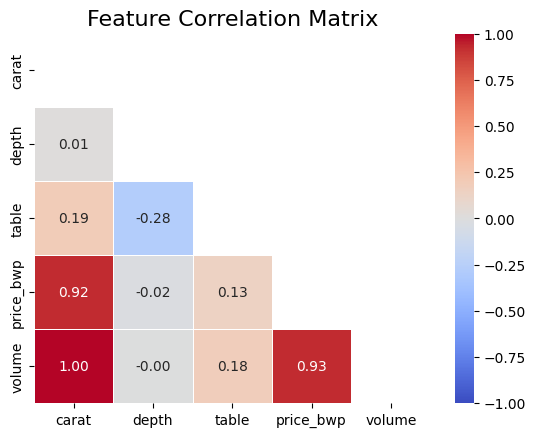

In [14]:
# Correlation matrix
corr = df_clean.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))


sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            vmin=-1, vmax=1, linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.show()

**Price variation across categories**

In [15]:
categorical_cols = df_clean.select_dtypes("category")
for col in categorical_cols:
    print(f"\nPrice statistics by {col}:")
    print(df_clean.groupby(col,observed=True)['price_bwp'].describe())


Price statistics by cut:
             count          mean           std     min      25%       50%  \
cut                                                                         
Fair         775.0  58159.585161  44224.045287  4549.5  28458.0  47007.00   
Good        4483.0  51865.545505  48405.102415  4522.5  14796.0  39960.00   
Ideal      21480.0  46146.716271  50587.091674  4401.0  11839.5  24293.25   
Premium    13670.0  60656.201170  57300.340302  4401.0  14053.5  41823.00   
Very Good  12003.0  53235.724319  52342.268072  4536.0  12271.5  35545.50   

                 75%       max  
cut                             
Fair       71705.250  250627.5  
Good       67250.250  252544.5  
Ideal      62667.000  253881.0  
Premium    83453.625  254110.5  
Very Good  71961.750  254043.0  

Price statistics by color:
         count          mean           std     min        25%       50%  \
color                                                                     
D       6641.0  42494.420

---

## Key Insights from EDA:

1. **Correlations**:
   - strong corelation between price , carat and volume, not suprising.
   - medium corelation between depth and table , others not so significant

2. **Quality Characteristics**:
   - Cut: Most diamonds are "Ideal" or "Premium" cut
   - Color: G and H colors are most common
   - Clarity: SI1 and VS2 clarity grades dominate the dataset

3. **Important Relationships**:
   - Carat has the strongest correlation with price (r=0.92)
   - Higher quality grades (better cut, better color, better clarity) command higher prices per carat
   - Volume shows a slightly stronger correlation with price than individual dimensions

4. **Unexpected Findings**:
   - Premium cut diamonds have higher median prices than Ideal cuts
   - J color diamonds have higher prices than I color due to larger average size
   - Depth between 58-64% and table between 53-59% are most common



### lets save this dataset

In [28]:
import pickle
from sklearn.model_selection import train_test_split

# Ensure your data is in a Pandas DataFrame and not the special AutoGluon TabularDataset yet
train, test = train_test_split(df_clean, test_size=0.2, random_state=7) 

clean_ds = {"train": train,
            "test": test
            }

save_dir = get_path("Data/clean_ds.pkl") 

#serialise and save cleaned data
with open(save_dir, "wb") as f:
    pickle.dump(clean_ds, f)

In [29]:
import pickle
data_dir = get_path("Data/clean_ds.pkl")
with open(data_dir, 'rb') as f:
    data = pickle.load(f)
data

{'train':        carat        cut color clarity      depth  table  price_bwp      volume
 19351   0.31      Ideal     E     VS2  61.799999   56.0     8397.0   51.135551
 38359   0.33      Ideal     F    VVS1  62.400002   55.0    13783.5   55.174103
 47767   0.55    Premium     D     VS2  61.599998   56.0    25569.0   92.025650
 48531   0.73  Very Good     G     SI2  62.599998   56.0    26811.0  120.938034
 16805   1.01    Premium     F     VS2  60.799999   57.0    90477.0  166.628372
 ...      ...        ...   ...     ...        ...    ...        ...         ...
 14416   1.05    Premium     D     SI1  58.599998   60.0    78583.5  175.701462
 969     0.82  Very Good     G     SI2  62.500000   56.0    39055.5  136.035294
 39601   0.30      Ideal     I     VS1  62.400002   54.0     6628.5   49.969448
 11164   1.14    Premium     H     SI1  62.500000   58.0    66798.0  187.078812
 51112   0.83       Good     H     SI2  63.900002   56.0    31549.5  135.333862
 
 [41928 rows x 8 columns],
 '

### Evaluate the perfomace 

In [34]:
pd.read_csv(get_path("Logs/Autogluon/leaderboard.csv")).drop(columns=["Unnamed: 0"]).iloc[:, :5]

,model,score_test,score_val,eval_metric,pred_time_test
0,WeightedEnsemble_L2,-5261.3320,-5184.6750,root_mean_squared_error,3.534255
1,CatBoost,-5350.6597,-5308.4850,root_mean_squared_error,0.136682
2,LightGBM,-5410.6187,-5334.3022,root_mean_squared_error,0.462424
3,LightGBMXT,-5443.2783,-5362.3096,root_mean_squared_error,1.728732
4,RandomForestMSE,-5644.1675,-5554.4224,root_mean_squared_error,1.198162
